# Libraries

In [1]:
import transformers 
import datasets
print("transformers version:", transformers.__version__)
print("datasets version:", datasets.__version__)

import os
os.listdir("pest dataset")

import warnings
warnings.filterwarnings("ignore")

transformers version: 4.23.1
datasets version: 2.6.1


# Load the Data

In [2]:
from datasets import load_dataset
data_dir = "pest dataset"

train_ds = load_dataset("imagefolder", data_dir=os.path.join(data_dir, "train"), split="train")
val_ds = load_dataset("imagefolder", data_dir=os.path.join(data_dir, "valid"), split="train")
test_ds = load_dataset("imagefolder", data_dir=os.path.join(data_dir, "test"), split="train")


id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}

print("Features", train_ds.features)
print("Train", train_ds)
print("Validation", val_ds)
print("Test", test_ds)
print("Num labels", len(label2id))
print("Label2Idx", label2id)
print("Idx2Label", id2label)

Resolving data files:   0%|          | 0/4817 [00:00<?, ?it/s]

Using custom data configuration default-c0820e2165bfc38b


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to C:/Users/Cocoritter/.cache/huggingface/datasets/imagefolder/default-c0820e2165bfc38b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Resolving data files:   0%|          | 0/598 [00:00<?, ?it/s]

Using custom data configuration default-71e6a62a86f8a4bb


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to C:/Users/Cocoritter/.cache/huggingface/datasets/imagefolder/default-71e6a62a86f8a4bb/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Resolving data files:   0%|          | 0/608 [00:00<?, ?it/s]

Using custom data configuration default-7028eeb4b5fc0780


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to C:/Users/Cocoritter/.cache/huggingface/datasets/imagefolder/default-7028eeb4b5fc0780/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.
Features {'image': Image(decode=True, id=None), 'label': ClassLabel(names=['brown-planthopper', 'green-leafhopper', 'leaf-folder', 'rice-bug', 'stem-borer', 'whorl-maggot'], id=None)}
Train Dataset({
    features: ['image', 'label'],
    num_rows: 4817
})
Validation Dataset({
    features: ['image', 'label'],
    num_rows: 598
})
Test Dataset({
    features: ['image', 'label'],
    num_rows: 608
})
Num labels 6
Label2Idx {'brown-planthopper': 0, 'green-leafhopper': 1, 'leaf-folder': 2, 'rice-bug': 3, 'stem-borer': 4, 'whorl-maggot': 5}
Idx2Label {0: 'brown-planthopper', 1: 'green-leafhopper', 2: 'leaf-folder', 3: 'rice-bug', 4: 'stem-borer', 5: 'whorl-maggot'}


# Transforms

In [3]:
from transformers import AutoFeatureExtractor
from torchvision.transforms import (
    CenterCrop, 
    Compose, 
    Normalize, 
    RandomHorizontalFlip,
    RandomResizedCrop, 
    Resize, 
    ToTensor
)

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

# Data Loader

In [4]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

# Defining the Model

In [5]:
from transformers import SwinForImageClassification, SwinConfig

config = SwinConfig.from_pretrained(
        "microsoft/swin-tiny-patch4-window7-224",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        finetuning_task="image-classification"
    )

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    config=config,
    ignore_mismatched_sizes=True
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# TrainingArguments

In [6]:
from transformers import TrainingArguments, Trainer
metric_name = "accuracy"
args = TrainingArguments(
    f"pest dataset",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

# Load Metric

In [7]:
from datasets import load_metric
import numpy as np

metric = load_metric(metric_name)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Training 

In [8]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [9]:
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"
train_results = trainer.train()
train_results

***** Running training *****
  Num examples = 4817
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 755
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.129016,0.966555
2,No log,0.064608,0.988294
3,No log,0.046057,0.986622
4,0.317300,0.032886,0.991639
5,0.317300,0.032396,0.989967


***** Running Evaluation *****
  Num examples = 598
  Batch size = 32
Saving model checkpoint to pest dataset\checkpoint-151
Configuration saved in pest dataset\checkpoint-151\config.json
Model weights saved in pest dataset\checkpoint-151\pytorch_model.bin
Feature extractor saved in pest dataset\checkpoint-151\preprocessor_config.json
***** Running Evaluation *****
  Num examples = 598
  Batch size = 32
Saving model checkpoint to pest dataset\checkpoint-302
Configuration saved in pest dataset\checkpoint-302\config.json
Model weights saved in pest dataset\checkpoint-302\pytorch_model.bin
Feature extractor saved in pest dataset\checkpoint-302\preprocessor_config.json
Deleting older checkpoint [pest dataset\checkpoint-151] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 598
  Batch size = 32
Saving model checkpoint to pest dataset\checkpoint-453
Configuration saved in pest dataset\checkpoint-453\config.json
Model weights saved in pest dataset\checkpoint-453\py

TrainOutput(global_step=755, training_loss=0.2434087437509701, metrics={'train_runtime': 7407.1653, 'train_samples_per_second': 3.252, 'train_steps_per_second': 0.102, 'total_flos': 5.98723406341079e+17, 'train_loss': 0.2434087437509701, 'epoch': 5.0})

# Validation

In [10]:
eval_results = trainer.evaluate()
eval_results

***** Running Evaluation *****
  Num examples = 598
  Batch size = 32


{'eval_loss': 0.032885875552892685,
 'eval_accuracy': 0.9916387959866221,
 'eval_runtime': 75.9393,
 'eval_samples_per_second': 7.875,
 'eval_steps_per_second': 0.25,
 'epoch': 5.0}

# Evaluation on Test Set

In [11]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
labels = train_ds.features['label'].names

***** Running Prediction *****
  Num examples = 608
  Batch size = 32


{'test_loss': 0.0590367391705513, 'test_accuracy': 0.9884868421052632, 'test_runtime': 71.662, 'test_samples_per_second': 8.484, 'test_steps_per_second': 0.265}


# Classification Report

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

                   precision    recall  f1-score   support

brown-planthopper       1.00      0.93      0.96       102
 green-leafhopper       0.98      1.00      0.99        99
      leaf-folder       1.00      1.00      1.00       102
         rice-bug       0.95      1.00      0.98       102
       stem-borer       1.00      1.00      1.00       100
     whorl-maggot       1.00      1.00      1.00       103

         accuracy                           0.99       608
        macro avg       0.99      0.99      0.99       608
     weighted avg       0.99      0.99      0.99       608



# Confusion Matrix

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
cm = confusion_matrix(y_true, y_pred)

In [106]:
# Plot confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix of Swin Transformer',
                          cmap=None,
                          normalize=False):
   
    
    # Accuracy score
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    # Colormap gradient
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Show classification classes
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    # Plot raw numbers or proportions
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
   
    # Text settings
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted class Accuracy= {:0.4f}'.format(accuracy, misclass), size = 20)
    plt.show()

In [107]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
cm = confusion_matrix(y_true, y_pred)

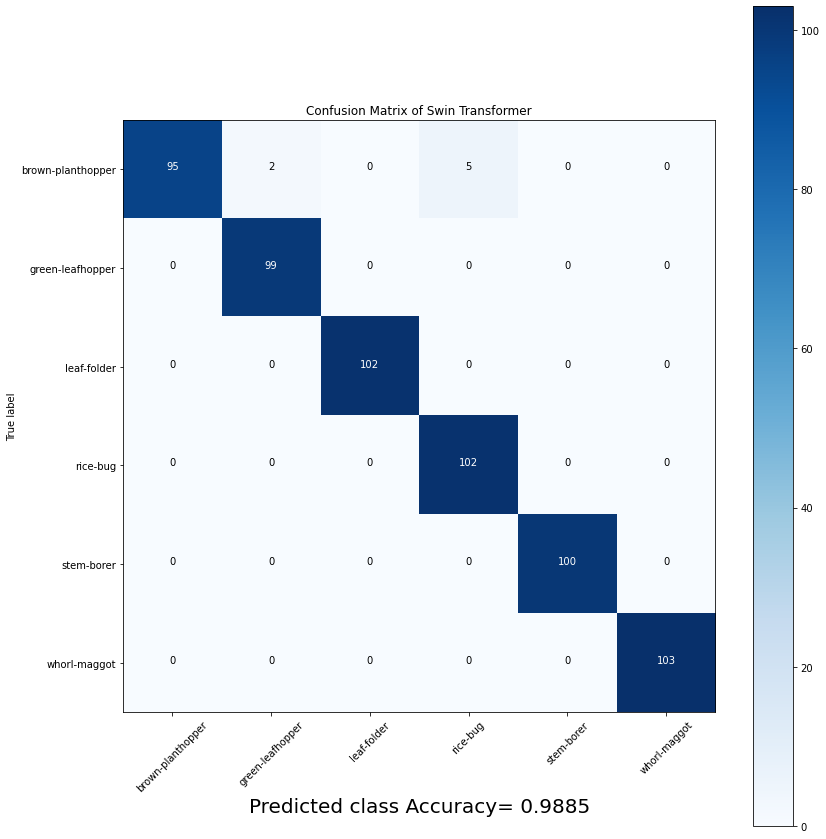

In [108]:
import itertools

plot_confusion_matrix(cm, labels)
plt.show()

# Visualize Some Predicted Results

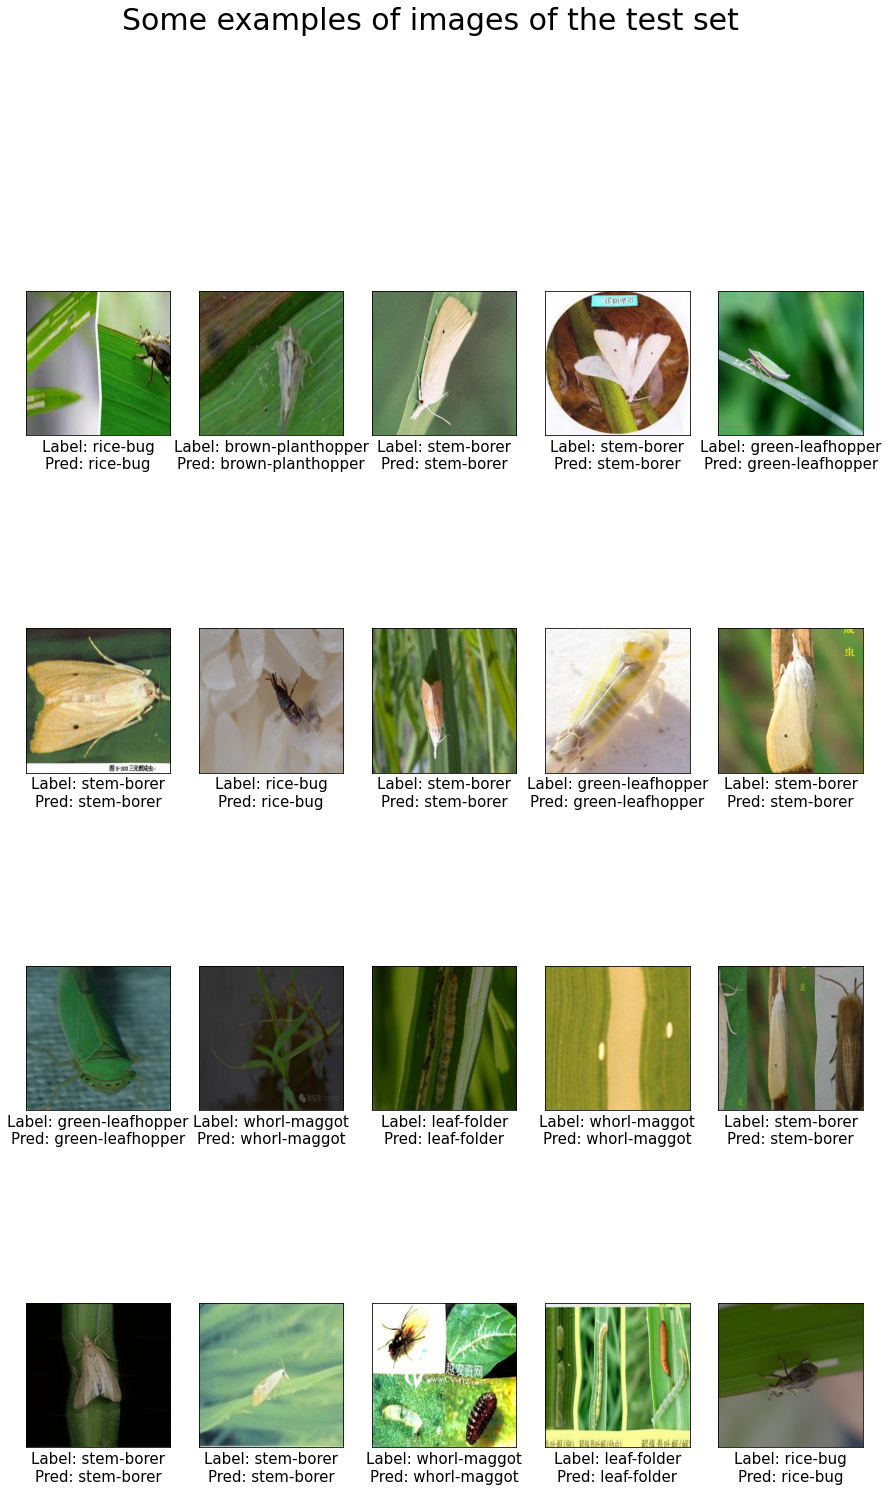

In [109]:
import cv2
import matplotlib.pyplot as plt
from random import randint

list_idx = [randint(0, len(test_ds)) for i in range(20)]

def display_examples():
    fig = plt.figure(figsize=(15,30))
    fig.suptitle("Some examples of images of the test set", fontsize=30)
    for i,idx in enumerate(list_idx):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_ds[idx]["image"], cmap=plt.cm.binary)
        plt.xlabel("Label: "+id2label[y_true[idx]]+"\nPred: "+id2label[y_pred[idx]], size = 15)
    plt.show()

display_examples()

In [110]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       102
           1       0.98      1.00      0.99        99
           2       1.00      1.00      1.00       102
           3       0.95      1.00      0.98       102
           4       1.00      1.00      1.00       100
           5       1.00      1.00      1.00       103

    accuracy                           0.99       608
   macro avg       0.99      0.99      0.99       608
weighted avg       0.99      0.99      0.99       608

